## Preparing the notebook

In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('..\\personal_plot.mplstyle')

In [2]:
domains = pd.read_csv("Data\\Domain Information.csv", index_col=0)

for i in domains.index:
    domains.loc[i, "Creation date"] = datetime.datetime.strptime(domains.loc[i, "Creation date"], '%m/%d/%Y %H:%M')
    domains.loc[i, "Experation date"] = datetime.datetime.strptime(domains.loc[i, "Experation date"], '%m/%d/%Y %H:%M')
    domains.loc[i, "Update date"] = datetime.datetime.strptime(domains.loc[i, "Update date"], '%m/%d/%Y %H:%M')

domains.head()

,Creation date,Experation date,Update date
aa.com,1998-01-02 05:00:00,2020-01-01 05:00:00,2018-12-02 06:07:00
aaa.com,1990-08-03 04:00:00,2028-08-02 04:00:00,2018-08-02 20:48:00
aab.com,2001-06-24 10:42:00,2022-06-24 10:42:00,2017-06-07 13:15:00
aac.com,1992-09-21 04:00:00,2027-09-20 04:00:00,2017-09-21 00:41:00
aad.com,1995-09-20 04:00:00,2019-09-19 04:00:00,2018-08-21 16:01:00


In [3]:
nasdaq = pd.read_csv("Data\\NASDAQ Composite.csv")

for i in nasdaq.index:
    nasdaq.loc[i, "Date"] = datetime.datetime.strptime(nasdaq.loc[i, "Date"], '%Y-%m-%d')

nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1984-01-01 00:00:00,277.630005,287.899994,268.429993,268.429993,268.429993,0
1,1984-02-01 00:00:00,266.429993,266.429993,247.089996,252.570007,252.570007,0
2,1984-03-01 00:00:00,253.500000,255.539993,249.009995,250.779999,250.779999,0
3,1984-04-01 00:00:00,249.800003,249.800003,241.789993,247.440002,247.440002,0
4,1984-05-01 00:00:00,250.259995,253.009995,231.929993,232.820007,232.820007,0


## Bucket the domains

In [4]:
buckets = []

data_creation = domains.sort_values(['Creation date'])
first_date = data_creation['Creation date'][0]
last_date = data_creation['Creation date'][-1]

months = (last_date.year - first_date.year) * 12 + (last_date.month - first_date.month) + 2

start_year = first_date.year
start_month = first_date.month

years = 0

for month in range(months):
    month = month - years * 12

    buckets.append(datetime.datetime(year = start_year + years,
                                     month = start_month + month,
                                     day = 1))
    if (start_month + month) % 12 == 0:
        years += 1

In [5]:
import numpy as np
value_per_bucket = np.zeros(len(buckets))

for i in range(len(buckets)):
    values = 0
    
    for date in data_creation['Creation date']:
        if date >= buckets[-1]:
            values += 1
        
        elif date >= buckets[i] and date < buckets[i + 1]:
            values += 1
        
        elif date >= buckets[i]:
            break
    
    value_per_bucket[i] = values

In [6]:
domains_bucket = pd.DataFrame({'Buckets': buckets,
                               'Registrations': value_per_bucket,
                               'Cumulative': np.cumsum(value_per_bucket)})

domains_bucket.tail()

,Buckets,Registrations,Cumulative
396,2018-04-01,0.0,18249.0
397,2018-05-01,2.0,18251.0
398,2018-06-01,0.0,18251.0
399,2018-07-01,1.0,18252.0
400,2018-08-01,0.0,18252.0


In [7]:
domains_bucket.head()

,Buckets,Registrations,Cumulative
0,1985-04-01,1.0,1.0
1,1985-05-01,0.0,1.0
2,1985-06-01,0.0,1.0
3,1985-07-01,1.0,2.0
4,1985-08-01,0.0,2.0


## Plotting
### Plotting number of registrations vs. the Nasdaq

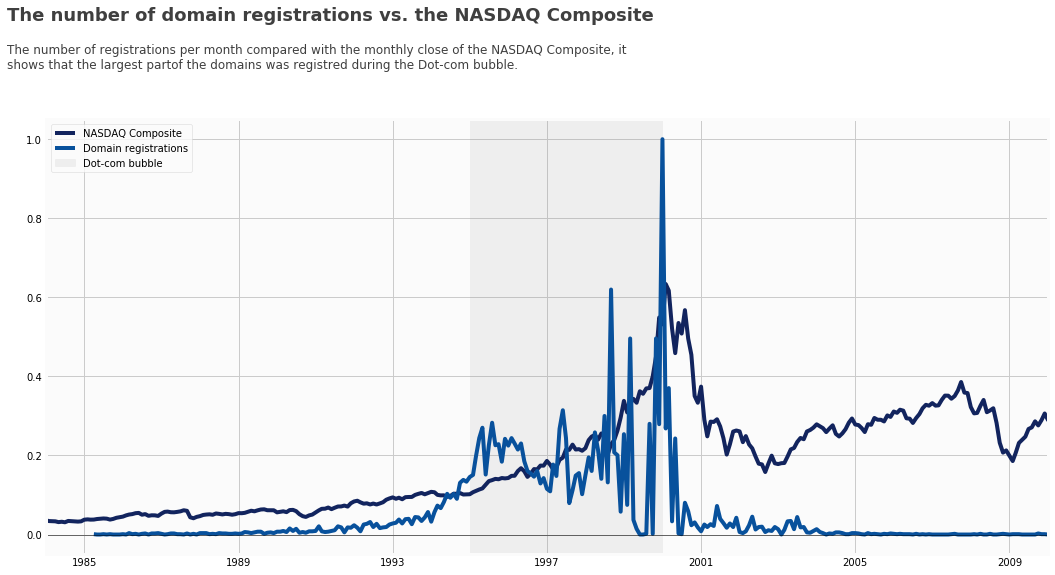

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(nasdaq['Date'], nasdaq['Close'] / np.max(nasdaq['Close']), label = 'NASDAQ Composite')
plt.plot(domains_bucket['Buckets'], domains_bucket['Registrations'] / np.max(domains_bucket['Registrations']), label = 'Domain registrations')
plt.axvspan(datetime.datetime(1995, 1, 1), datetime.datetime(2000, 1, 1), color = 'grey', alpha = 0.1, label = 'Dot-com bubble')
plt.legend(loc = "upper left")
#plt.ylim([0, 1.1])
plt.xlim([datetime.datetime(1984, 1, 1), datetime.datetime(2010, 1, 1)])
plt.xticks([datetime.datetime(1985, 1, 1),
            datetime.datetime(1989, 1, 1),
            datetime.datetime(1993, 1, 1),
            datetime.datetime(1997, 1, 1),
            datetime.datetime(2001, 1, 1),
            datetime.datetime(2005, 1, 1),
            datetime.datetime(2009, 1, 1)])

plt.axhline(y = 0, color = 'black', alpha = 0.5, linewidth = 1)

plt.text(x = datetime.datetime(1983, 1, 1), 
         y = 1.3, 
         s = "The number of domain registrations vs. the NASDAQ Composite",
         fontsize = 18, weight = 'bold', alpha = .75)
plt.text(x = datetime.datetime(1983, 1, 1), 
         y = 1.18, 
         s = "The number of registrations per month compared with the monthly close of the NASDAQ Composite, it" + 
             "\nshows that the largest partof the domains was registred during the Dot-com bubble.",
         fontsize = 12, alpha = .75)

plt.savefig("..\\..\\uijl.github.io_blog\\figures\\short-domain-names-registrations-vs-nasdaq.png", bbox_inches = 'tight')
plt.show()

### Plotting the cummulative number of registrations over time

In [9]:
seconds = []
for date in domains_bucket['Buckets']:
    seconds.append((date.timestamp()))

thousands = np.linspace(1000, list(domains_bucket['Cumulative'])[-1] - 1000, 2)    
thousands_seconds = np.interp(thousands, domains_bucket['Cumulative'], seconds)
thousands_dates = []

for date in thousands_seconds:
    thousands_dates.append(datetime.date.fromtimestamp(date))

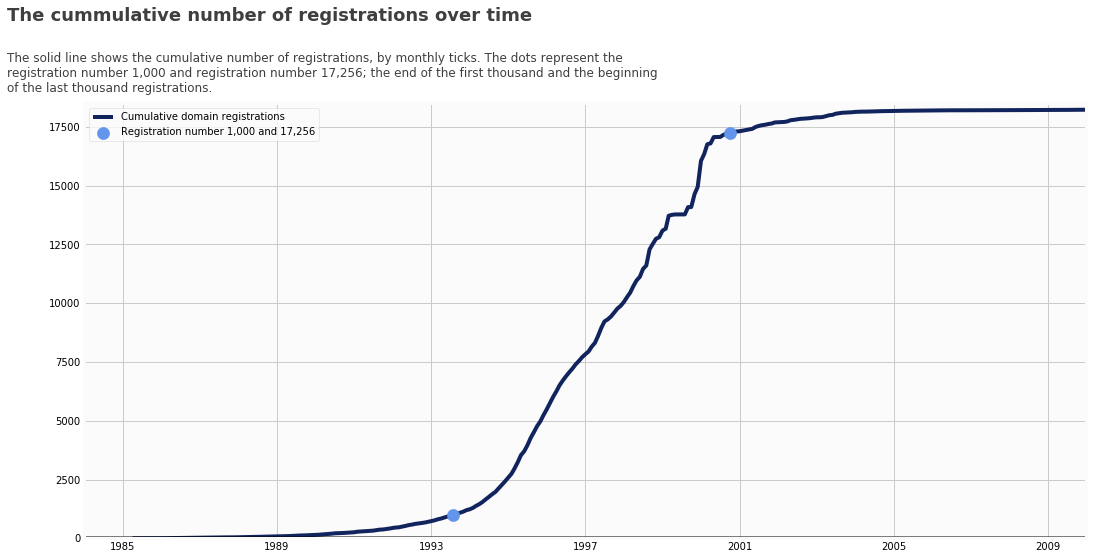

In [10]:
plt.figure(figsize = (16, 8))

plt.plot(domains_bucket['Buckets'], domains_bucket['Cumulative'], 
         label = 'Cumulative domain registrations', zorder = 1)
plt.scatter(thousands_dates, thousands, color = 'cornflowerblue', s = 150, marker = 'o', 
            label = 'Registration number 1,000 and 17,256', zorder = 2)
plt.legend(loc = "upper left")
plt.ylim([0, 18500])
plt.xlim([datetime.datetime(1984, 1, 1), datetime.datetime(2010, 1, 1)])
plt.xticks([datetime.datetime(1985, 1, 1),
            datetime.datetime(1989, 1, 1),
            datetime.datetime(1993, 1, 1),
            datetime.datetime(1997, 1, 1),
            datetime.datetime(2001, 1, 1),
            datetime.datetime(2005, 1, 1),
            datetime.datetime(2009, 1, 1)])

plt.axhline(y = 0, color = 'black', alpha = 0.5)

plt.text(x = datetime.datetime(1982, 1, 1), 
         y = 22000, 
         s = "The cummulative number of registrations over time",
         fontsize = 18, weight = 'bold', alpha = .75)
plt.text(x = datetime.datetime(1982, 1, 1), 
         y = 19000, 
         s = "The solid line shows the cumulative number of registrations, by monthly ticks. The dots represent the" +
             "\nregistration number 1,000 and registration number 17,256; the end of the first thousand and the beginning" +
             "\nof the last thousand registrations.",
         fontsize = 12, alpha = .75)

plt.savefig("..\\..\\uijl.github.io_blog\\figures\\short-domain-names-cumulative-registrations.png", bbox_inches = 'tight')
plt.show()

## Tables
### First 20 registred domains

In [11]:
earliest_domains = domains.sort_values(['Creation date'])

print('Converted to markdown\n')

print('| Domain names | Creation date |')
print('|--------------|---------------|')

for index in earliest_domains.head(20).index:
    if len(index) == 6:
        print('| {}       | {}    |'.format(index, str(earliest_domains['Creation date'][index])[:10]))
    else:
        print('| {}      | {}    |'.format(index, str(earliest_domains['Creation date'][index])[:10]))

Converted to markdown

| Domain names | Creation date |
|--------------|---------------|
| bbn.com      | 1985-04-24    |
| mcc.com      | 1985-07-11    |
| dec.com      | 1985-09-30    |
| sri.com      | 1986-01-17    |
| hp.com       | 1986-03-03    |
| ibm.com      | 1986-03-19    |
| sun.com      | 1986-03-19    |
| ti.com       | 1986-03-25    |
| att.com      | 1986-04-25    |
| gmr.com      | 1986-05-08    |
| tek.com      | 1986-05-08    |
| fmc.com      | 1986-07-10    |
| ub.com       | 1986-07-10    |
| isc.com      | 1986-08-05    |
| nsc.com      | 1986-08-05    |
| ge.com       | 1986-08-05    |
| ray.com      | 1986-10-27    |
| bdm.com      | 1986-10-27    |
| nec.com      | 1986-10-27    |
| gte.com      | 1986-11-05    |


### Last 20 registred domains

In [12]:
print('Converted to markdown\n')

print('| Domain names | Creation date |')
print('|--------------|---------------|')

for index in earliest_domains.tail(20).index:
    if len(index) == 6:
        print('| {}       | {}    |'.format(index, str(earliest_domains['Creation date'][index])[:10]))
    else:
        print('| {}      | {}    |'.format(index, str(earliest_domains['Creation date'][index])[:10]))

Converted to markdown

| Domain names | Creation date |
|--------------|---------------|
| qpe.com      | 2010-06-05    |
| yds.com      | 2010-11-21    |
| ihh.com      | 2011-04-01    |
| xte.com      | 2011-04-15    |
| ycp.com      | 2011-05-19    |
| syc.com      | 2011-06-24    |
| hzg.com      | 2011-07-03    |
| iqw.com      | 2012-02-01    |
| wgj.com      | 2013-04-06    |
| kjq.com      | 2013-04-28    |
| bsf.com      | 2013-09-03    |
| cnm.com      | 2013-09-25    |
| zfn.com      | 2014-07-24    |
| cm.com       | 2015-01-16    |
| pdm.com      | 2015-04-05    |
| viq.com      | 2016-11-05    |
| xci.com      | 2017-02-15    |
| rxj.com      | 2018-05-09    |
| njd.com      | 2018-05-13    |
| btm.com      | 2018-07-19    |
